In [86]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

from metpy.plots import SkewT

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from skimage.measure import label, regionprops
import pickle as pickle

from scipy import ndimage
import gc



In [87]:
def LCL_Bolton(T, e):
    Tlcl = 2840 / (3.5 * np.log(T) - np.log(e) - 4.805) + 55
    return Tlcl

In [88]:
def LCL_Bolton_RH(Ts, RH):
    Tlcl = 1 / ( 1/(Ts - 55) - np.log(RH/100)/ 2840 ) + 55
    return Tlcl

# Read Data

In [89]:
%%capture

#Virtual Temperature
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_ALL_3D_P.nc'
all_P = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_T.nc'
all_T = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_RELHUM.nc'
all_RELHUM = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QV.nc'
all_QV = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_QC.nc'
all_QC = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_ALL_3D_W.nc'
all_W = xr.open_mfdataset(path+file).squeeze()

#TWATER
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_ALL.nc'
all_2D= xr.open_mfdataset(path+file)

#Wet-Day Frequency
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/RCE_300_3km_1006x1006_ALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
all_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens').squeeze()


#Landmask
path = '/scratch/snx3000/davidle/RCE-LND_new/RCE_300_3km_1006x1006_ALL_ens0/output/'
file='lffd2011032100c.nc'
all_const = xr.open_mfdataset(path+file).squeeze()

In [90]:
%%capture

#Virtual Temperature
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_SMALL_3D_P.nc'
small_P = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_T.nc'
small_T = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_RELHUM.nc'
small_RELHUM = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_QV.nc'
small_QV = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_QC.nc'
small_QC = xr.open_mfdataset(path+file).squeeze()
file='ensmean_daycycle_SMALL_3D_W.nc'
small_W = xr.open_mfdataset(path+file).squeeze()

#TWATER
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
file='ensmean_daycycle_SMALL.nc'
small_2D= xr.open_mfdataset(path+file)

#Wet-Day Frequency
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/RCE_300_3km_1006x1006_SMALL_ens?/precip_stats/'
file='precip_wd_freq_2D_eq.nc'
small_wd_freq= xr.open_mfdataset(path+file, concat_dim='ens').squeeze()


#Landmask
path = '/scratch/snx3000/davidle/RCE-LND_new/RCE_300_3km_1006x1006_SMALL_ens0/output/'
file='lffd2011032100c.nc'
small_const = xr.open_mfdataset(path+file).squeeze()

In [91]:
all_fr_land = all_const.FR_LAND[4:-4,4:-4]
all_land = all_fr_land
all_coast = ndimage.binary_dilation(all_fr_land, iterations=20) - all_fr_land - (ndimage.binary_dilation(all_fr_land, iterations=3) - all_fr_land) #cost is 60km wide
all_ocean = np.ones_like(all_fr_land) - ndimage.binary_dilation(all_fr_land, iterations=20)

#Clip to wet regions
cwv = all_2D.TWATER.mean(axis=(0))
all_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
all_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

all_wland=np.where(all_wetmask, all_land, 0)
all_wocean=np.where(all_wetmask, all_ocean, 0)
all_coastal_ocean=np.where(all_wetmask, all_coast, 0)
all_dry_ocean=np.where(all_drymask, all_ocean, 0)

In [92]:
small_fr_land = small_const.FR_LAND[4:-4,4:-4]
small_land = small_fr_land
small_coast = ndimage.binary_dilation(small_fr_land, iterations=20) - small_fr_land - (ndimage.binary_dilation(small_fr_land, iterations=3) - small_fr_land) #cost is 60km wide
small_ocean = np.ones_like(small_fr_land) - ndimage.binary_dilation(small_fr_land, iterations=20)

#Clip to wet regions
cwv = small_2D.TWATER.mean(axis=(0))
small_wetmask=np.where(cwv > np.percentile(cwv, 50), 1, 0)
small_drymask=np.where(cwv > np.percentile(cwv, 50), 0, 1)

small_wland=np.where(small_wetmask, small_land, 0)
small_wocean=np.where(small_wetmask, small_ocean, 0)
small_coastal_ocean=np.where(small_wetmask, small_coast, 0)
small_dry_ocean=np.where(small_drymask, small_ocean, 0)

In [93]:
LCL_all_lnd = LCL_Bolton_RH(np.average(all_T.T[11,-1,:,:],weights=all_wland), np.average(all_RELHUM.RELHUM[11,-1,:,:],weights=all_wland))
LCL_all_ocn = LCL_Bolton_RH(np.average(all_T.T[4,-1,:,:],weights=all_wocean), np.average(all_RELHUM.RELHUM[4,-1,:,:],weights=all_wocean))
dLCL_all = LCL_all_lnd - LCL_all_ocn

In [94]:
LCL_small_lnd = LCL_Bolton_RH(np.average(small_T.T[11,-1,:,:],weights=small_wland), np.average(small_RELHUM.RELHUM[11,-1,:,:],weights=small_wland))
LCL_small_ocn = LCL_Bolton_RH(np.average(small_T.T[4,-1,:,:],weights=small_wocean), np.average(small_RELHUM.RELHUM[4,-1,:,:],weights=small_wocean))
dLCL_small = LCL_small_lnd - LCL_small_ocn

## Near-surface values

In [95]:
Ts_wet_islands_ALL=all_T.T[12,-1,:,:].where(all_wland).mean().values
Ts_wet_ocean_ALL=all_T.T[:,-1,:,:].mean(axis=0).where(all_wocean).mean().values

Ts_wet_islands_SMALL=small_T.T[12,-1,:,:].where(small_wland).mean().values
Ts_wet_ocean_SMALL=small_T.T[:,-1,:,:].mean(axis=0).where(small_wocean).mean().values

print(np.mean(Ts_wet_islands_ALL) - np.mean(Ts_wet_ocean_ALL)) 
print(np.mean(Ts_wet_islands_SMALL) - np.mean(Ts_wet_ocean_SMALL)) 

1.6266174
1.714508


In [96]:
RH_wet_islands_ALL=all_RELHUM.RELHUM[12,-1,:,:].where(all_wland).mean().values
RH_wet_ocean_ALL=all_RELHUM.RELHUM[:,-1,:,:].mean(axis=0).where(all_wocean).mean().values

RH_wet_islands_SMALL=small_RELHUM.RELHUM[12,-1,:,:].where(small_wland).mean().values
RH_wet_ocean_SMALL=small_RELHUM.RELHUM[:,-1,:,:].mean(axis=0).where(small_wocean).mean().values

print(np.mean(RH_wet_islands_ALL) - np.mean(RH_wet_ocean_ALL)) 
print(np.mean(RH_wet_islands_SMALL) - np.mean(RH_wet_ocean_SMALL)) 

-7.052513
-8.487442


In [97]:
def composite_lcl_diurnal_cycle(fld,index):
    #This is slow, but requires less memory than np.take()
    out= np.empty(np.shape(index), dtype=float)
    for t,k,j,i in np.ndindex(np.shape(fld)):
        out[t,j,i] = fld[t,index[t,j,i],j,i]
    return out

In [98]:
path = '/scratch/snx3000/davidle/RCE-LND_new/analysis/ensmean/'
try:
    all_T_lcl  = pickle.load( open( path+'T_lcl.pkl', "rb" ) )
except:
    all_T_lcl = composite_lcl_diurnal_cycle(all_T.T.values,all_ilcl.values)
    with open(path+'T_lcl.pkl', 'wb') as pickle_file:
        pickle.dump(all_T_lcl, pickle_file)
        
try:
    small_T_lcl  = pickle.load( open( path+'T_lcl_SMALL.pkl', "rb" ) )
except:
    small_T_lcl = composite_lcl_diurnal_cycle(small_T.T.values,small_ilcl.values)
    with open(path+'T_lcl_SMALL.pkl', 'wb') as pickle_file:
        pickle.dump(small_T_lcl, pickle_file)

In [99]:
Tlcl_wet_islands_ALL=np.average(all_T_lcl[12,:,:], weights=all_wland)
Tlcl_wet_ocean_ALL=np.average(np.mean(all_T_lcl[:,:,:], axis=0), weights=all_wocean)

Tlcl_wet_islands_SMALL=np.average(small_T_lcl[12,:,:], weights=small_wland)
Tlcl_wet_ocean_SMALL=np.average(np.mean(small_T_lcl[:,:,:], axis=0), weights=small_wocean)

print(np.mean(Tlcl_wet_islands_ALL) - np.mean(Tlcl_wet_ocean_ALL)) 
print(np.mean(Tlcl_wet_islands_SMALL) - np.mean(Tlcl_wet_ocean_SMALL)) 

-0.36043755637513186
-0.7546704568447353


## LCL

In [100]:
def island_properties(fld, islands):
    island_labels = label(islands,neighbors=8)
    island_probs = regionprops(island_labels)

    area = np.zeros(len(island_probs))
    island_mean=np.zeros((len(island_probs)))

    island_probs = regionprops(island_labels,intensity_image=fld)
    for i in range(len(island_probs)):   
        area[i]=island_probs[i].area * 9 #Convert to km2
        island_mean[i]=island_probs[i].mean_intensity
        
    #Sort by isalnd size
    arr1inds = np.argsort(area)

    return area[arr1inds] , island_mean[arr1inds]

In [101]:
Ts_all_wet_islands=island_properties(all_T.T[12,-1,:,:].values, all_wland)
RH_all_wet_islands=island_properties(all_RELHUM.RELHUM[12,-1,:,:].values, all_wland)


Ts_small_wet_islands=island_properties(small_T.T[12,-1,:,:].values, small_wland)
RH_small_wet_islands=island_properties(small_RELHUM.RELHUM[12,-1,:,:].values, small_wland)

In [102]:
def add_rh_line(t, rh, mask, color='k'):

    mean = t.where(mask).compute().mean().values
    
    p5 = mean + rh.where(mask).compute().std().values
    p95 = mean - rh.where(mask).compute().std().values

    ax1.add_line(Line2D([mean,mean],[p5, p95], color=color, zorder=3, linewidth=2))

In [103]:
def add_t_line(t, rh, mask, color='k'):

    mean = rh.where(mask).compute().mean().values
    
    p5 = mean + t.where(mask).compute().std().values
    p95 = mean - t.where(mask).compute().std().values
    
    ax1.add_line(Line2D([p5, p95], [mean,mean], color=color, zorder=3, linewidth=2))

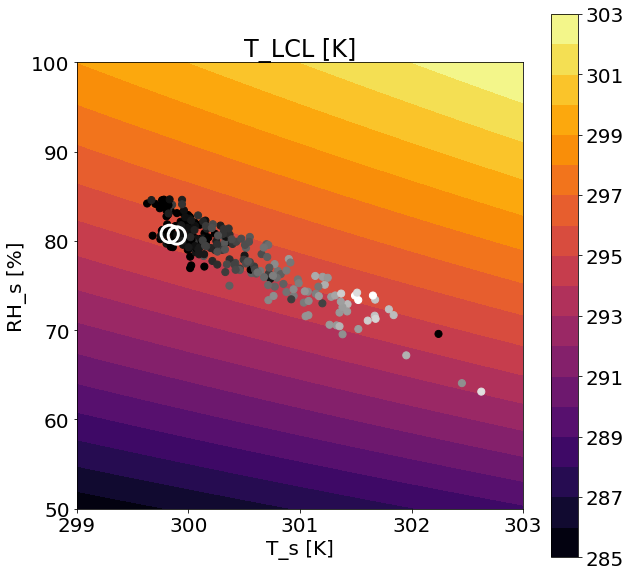

In [49]:
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 20})
plt.set_cmap('inferno')

Ts = np.linspace(299, 303, num=100)
RH = np.linspace(50, 100, num=100)

ax1=plt.subplot(1,1,1, aspect=1)
plt.title("T_LCL [K]")
plt.xlabel("T_s [K]")
plt.ylabel("RH_s [%]")
Ts_2D = np.tile(Ts, (len(Ts),1))
RH_2D = np.tile(RH.reshape((len(RH), 1)), len(RH)) 


plt.contourf(Ts_2D, RH_2D,  LCL_Bolton_RH( Ts_2D, RH_2D), levels=20)
plt.colorbar()

#LCL over islands
plt.scatter(Ts_all_wet_islands[1], RH_all_wet_islands[1], c=np.log(Ts_all_wet_islands[0]), zorder=2, s=50, alpha=1, cmap='gray')
plt.scatter(Ts_small_wet_islands[1], RH_small_wet_islands[1], c=np.log(Ts_small_wet_islands[0]), s=50, alpha=1, cmap='gray')

#plt.scatter(all_T.T[11,-1,:,:].where(all_wland).compute().mean(), all_RELHUM.RELHUM[11,-1,:,:].where(all_wland).compute().quantile(0.5), color='black', zorder=4)
plt.scatter(all_T.T[4,-1,:,:].where(all_wocean).compute().mean(), all_RELHUM.RELHUM[:,-1,:,:].mean(axis=0).where(all_wocean).compute().mean(), facecolors='none', edgecolors='white', zorder=4, s=300, linewidths=3)

#plt.scatter(small_T.T[11,-1,:,:].where(small_wland).compute().mean(), small_RELHUM.RELHUM[11,-1,:,:].where(small_wland).compute().quantile(0.5), color='white', zorder=4)
plt.scatter(small_T.T[4,-1,:,:].where(small_wocean).compute().mean(), small_RELHUM.RELHUM[:,-1,:,:].mean(axis=0).where(small_wocean).compute().mean(), facecolors='none', edgecolors='white', zorder=4, s=300, linewidths=3)



#add_t_line(all_T.T[11,-1,:,:], all_RELHUM.RELHUM[11,-1,:,:], all_wland, color='k')
#add_t_line(all_T.T[4,-1,:,:], all_RELHUM.RELHUM[4,-1,:,:], all_wocean, color='k')

#add_rh_line(all_T.T[11,-1,:,:], all_RELHUM.RELHUM[11,-1,:,:], all_wland, color='k')
#add_rh_line(all_T.T[4,-1,:,:], all_RELHUM.RELHUM[4,-1,:,:], all_wocean, color='k')

#add_t_line(small_T.T[11,-1,:,:], small_RELHUM.RELHUM[11,-1,:,:], small_wland, color='white')
#add_t_line(small_T.T[4,-1,:,:], small_RELHUM.RELHUM[4,-1,:,:], small_wocean, color='white')

#add_rh_line(small_T.T[11,-1,:,:], small_RELHUM.RELHUM[11,-1,:,:], small_wland, color='white')
#add_rh_line(small_T.T[4,-1,:,:], small_RELHUM.RELHUM[4,-1,:,:], small_wocean, color='white')


x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_aspect((x1-x0)/(y1-y0))

plt.savefig('Bolton.pdf')